# Machine Learning for Index Tracking Problem 

By: Jean Philippe N'DRI

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.cluster import AgglomerativeClustering,AffinityPropagation
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
def clean_name_col(name_col):
    res = name_col.lower()
    res = re.sub(r'[^\w\s]', '', res)
    return res

def list_col_supp(data,t):
    list_percent = (data.isnull().mean()*100)
    index_supp = [i for i, ele in enumerate(list_percent) if ele > t]
    return(data.iloc[:,index_supp].columns.to_list())

def list_row_supp(data):
    list_percent = data.isnull().sum(axis=1)/data.shape[0]
    index_supp = [i for i, ele in enumerate(list_percent) if ele > 50]
    return(index_supp)

def To_cat(ds):
    ds_cat = ds.select_dtypes(include = 'object').copy()
    return ds_cat

def To_num(ds):
    ds_num = ds.select_dtypes(exclude = 'object').copy()
    return ds_num

def download_adj_close(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']


In [20]:
SOX_tickers=['AMD','ADI','AMAT','ASML','AZTA','AVGO','COHR','ENTG','GFS','INTC'
            ,'IPGP','KLAC','LRCX','LSCC','MRVL','MCHP','MU','MPWR','NOVT','NVDA'
            , 'NXPI','ON','QRVO','QCOM','SWKS','SYNA','TSM','TER','TXN','WOLF'
            ,'^SOX']

In [21]:
# Exemple d'utilisation
prices = download_adj_close(SOX_tickers, '2018-01-01', '2023-12-31')
prices

[*********************100%%**********************]  31 of 31 completed


,ADI,AMAT,AMD,ASML,AVGO,AZTA,COHR,ENTG,GFS,INTC,...,ON,QCOM,QRVO,SWKS,SYNA,TER,TSM,TXN,WOLF,^SOX
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,80.471359,49.301422,10.980000,167.059860,216.090302,23.732574,48.400002,30.606756,NaN,39.857136,...,21.809999,55.204739,68.879997,88.106339,41.150002,42.728653,34.790039,88.872917,38.139118,1287.699951
2018-01-03,81.469681,50.175159,11.550000,168.328827,218.453461,23.915724,49.650002,30.655107,NaN,38.504452,...,22.780001,55.831295,68.389999,89.449028,41.560001,42.912418,35.375248,91.280586,37.889126,1309.859985
2018-01-04,81.380547,50.463318,12.120000,169.898544,218.526306,24.465178,48.599998,31.186983,NaN,37.798340,...,22.780001,55.907509,68.720001,90.200905,41.820000,43.115513,35.188667,91.162735,38.619106,1317.239990
2018-01-05,81.710358,50.751461,11.880000,171.891266,219.821198,25.178511,50.250000,31.670494,NaN,38.062077,...,22.830000,56.280045,68.029999,90.612663,42.230000,44.111683,36.011349,91.861473,38.349113,1325.709961
2018-01-08,81.852966,51.978424,12.280000,172.793640,220.347229,25.139946,51.250000,32.299076,NaN,38.062077,...,22.969999,56.110699,68.839996,90.630585,43.639999,44.672615,35.994389,92.299232,38.569111,1335.540039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,197.100006,162.050003,139.600006,752.530029,1121.979980,64.489998,44.610001,119.912422,60.340000,48.000000,...,84.010002,143.490005,112.599998,112.839996,118.029999,107.629997,103.150002,166.922775,44.430000,4132.850098
2023-12-26,198.869995,164.279999,143.410004,762.679993,1131.890015,65.760002,45.430000,121.371239,61.990002,50.500000,...,85.470001,145.460007,114.379997,114.510002,118.879997,110.349998,104.449997,169.472656,46.840000,4207.450195
2023-12-27,199.350006,164.210007,146.070007,764.030029,1126.170044,66.300003,44.810001,121.501129,62.240002,50.759998,...,85.050003,145.720001,114.610001,114.410004,118.470001,110.750000,104.650002,169.889359,46.509998,4214.589844


In [22]:
for i in [5,10,20,30,40,50]:
    print(list_col_supp(prices,i))

['GFS']
['GFS']
['GFS']
['GFS']
['GFS']
['GFS']


In [23]:
# Supprimer les actifs avec des valeurs Manquantes
elements_a_supprimer = ['GFS']
main_list = [element for element in SOX_tickers if element not in elements_a_supprimer]
prices=prices[main_list]

In [25]:
# Retrieve the first row (the starting point)
first_row = prices.iloc[0]

# Calculate the cumulative returns
# We divide each day's prices by the first day's prices
cumulative_returns = prices / first_row

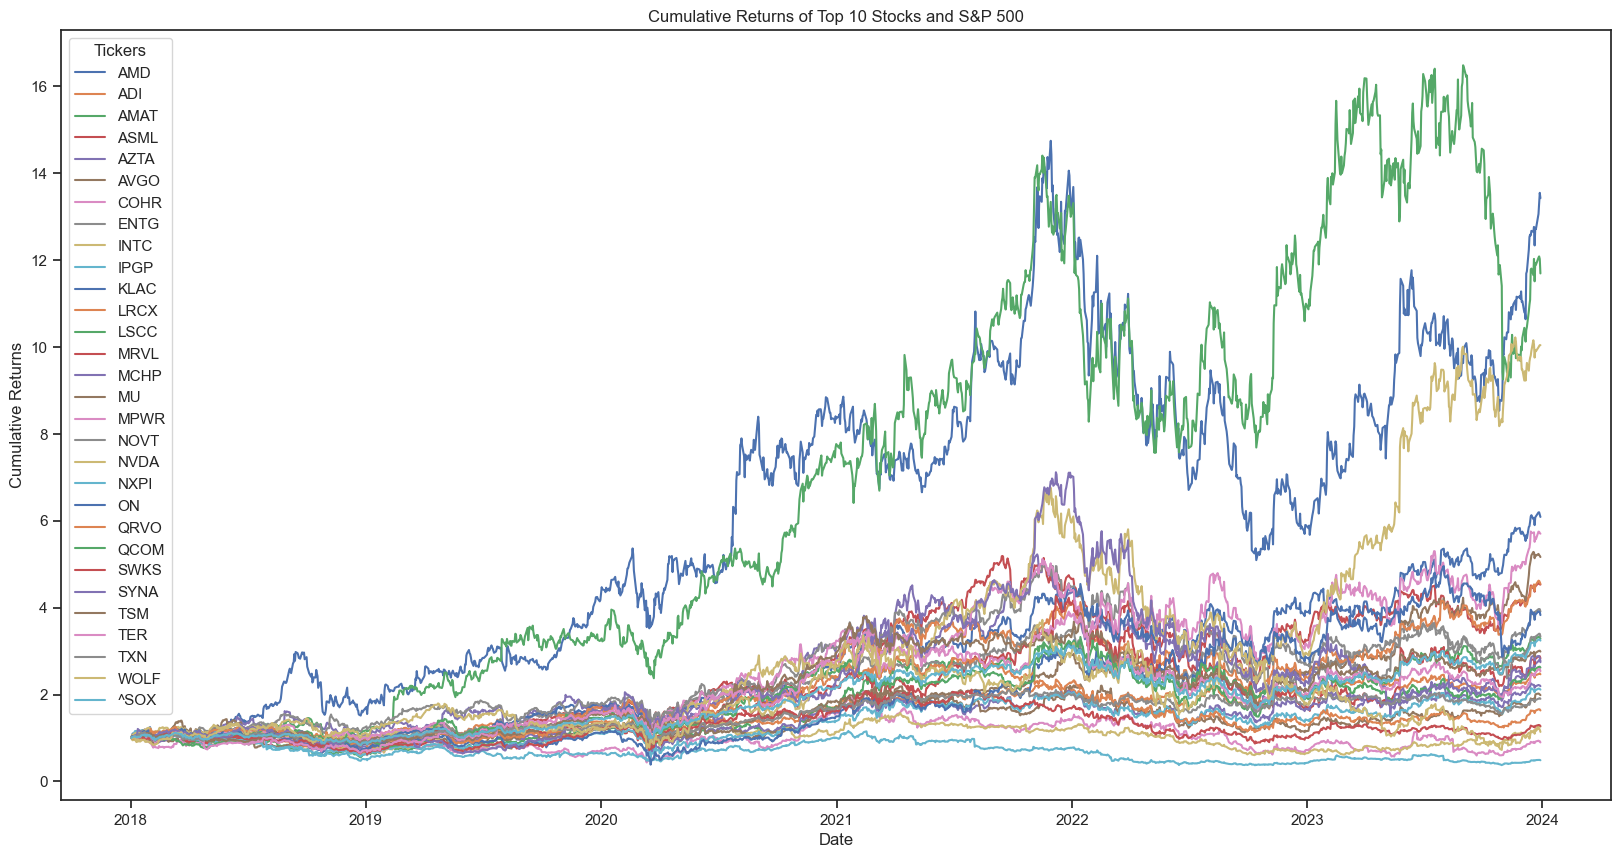

In [26]:
# Plotting the evolution
# Setting the seaborn style
sns.set(style="ticks")
# Plotting the evolution using seaborn's lineplot
plt.figure(figsize=(20, 10))
for column in cumulative_returns.columns:
    sns.lineplot(data=cumulative_returns[column], label=column)

plt.title("Cumulative Returns of Top 10 Stocks and S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(title="Tickers")
plt.show()


<Axes: title={'center': 'Correlation Matrix'}>

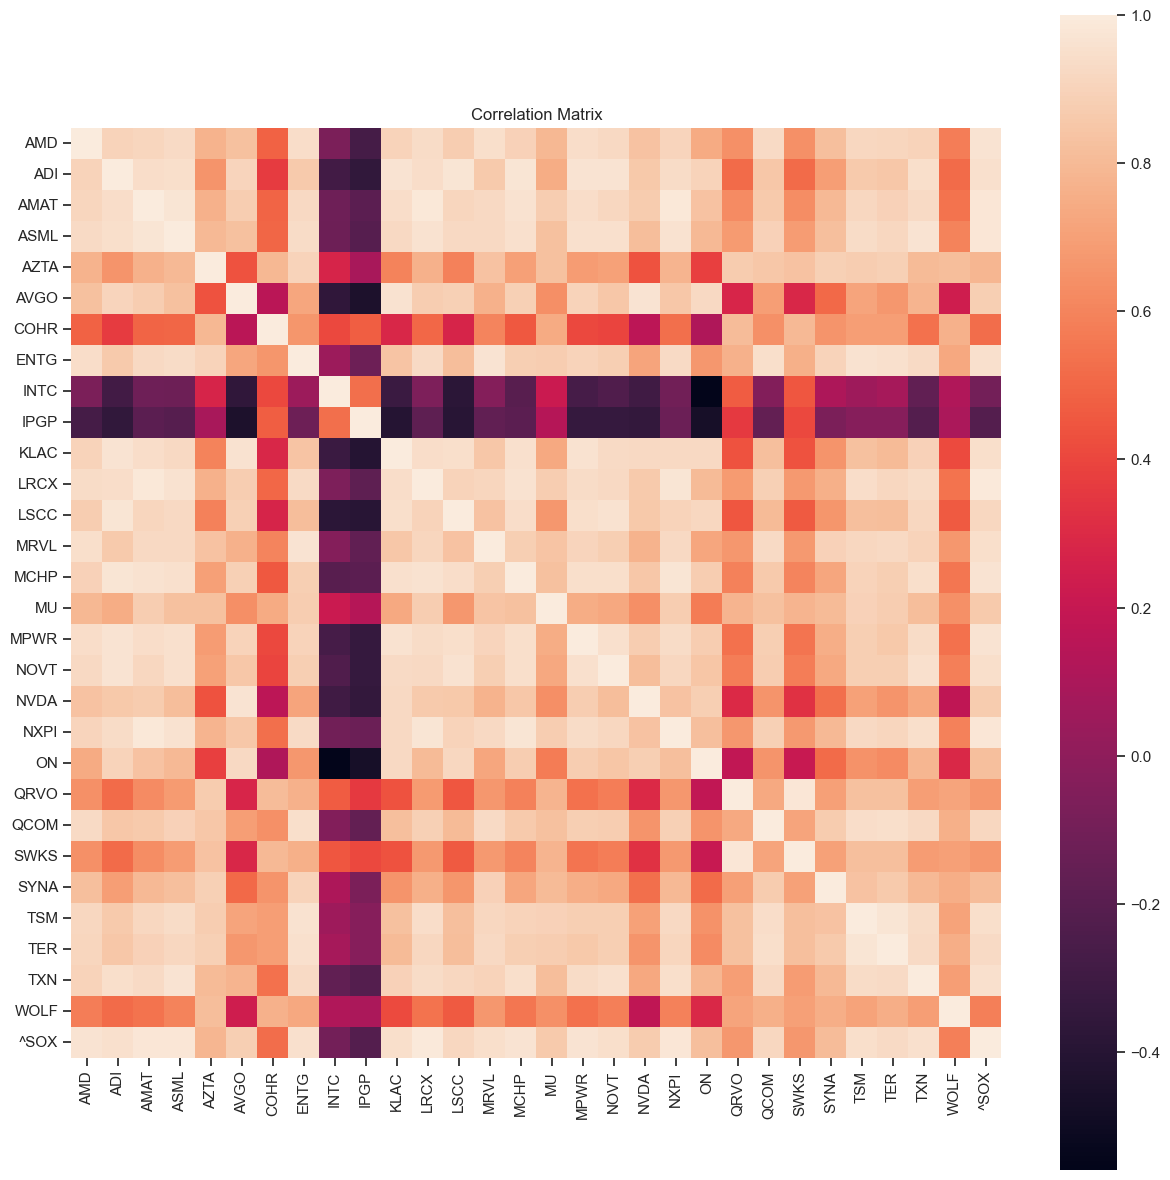

In [27]:
# correlation
correlation = prices.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=False)

In [28]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = prices.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = prices.pct_change().std() * np.sqrt(252)
data=returns

#Scale the data
scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset

In [30]:
X.head()

,Returns,Volatility
AMD,2.389442,1.443046
ADI,-0.566776,-1.495977
AMAT,0.146429,-0.002985
ASML,0.396170,-0.697304
AZTA,0.232162,1.202784


# Selection Methods

### Affinity Propagation Algorithm

Affinity Propagation (AP) is a clustering algorithm that does not require the number of clusters to be determined before running the algorithm. It operates by passing messages between data points and considering all data points as potential exemplars (cluster centers).

#### Key Concepts

1. **Exemplars**: Each cluster is represented by a data point known as an exemplar. Ideally, an exemplar is the most representative point of its cluster.

2. **Similarity**: The similarity (`s(i, k)`) between two points `i` and `k` is typically the negative square of the Euclidean distance. For a point `k`, the value of `s(k, k)`, called preference, influences the likelihood of `k` becoming an exemplar.

#### Mathematical Formulations

The algorithm proceeds by iteratively updating two types of messages:

1. **Responsibility** (`r(i, k)`): Sent from data point `i` to candidate exemplar `k`, this value reflects how well-suited `k` is to serve as the exemplar for `i`, considering other potential exemplars for `i`. It is calculated as:

   $$ r(i, k) \leftarrow s(i, k) - \max_{k' \neq k} \left\{ a(i, k') + s(i, k') \right\} $$

   where `a(i, k')` is the availability (see below) of point `k'` to be the exemplar for `i`.

2. **Availability** (`a(i, k)`): Sent from candidate exemplar `k` to data point `i`, this value indicates how appropriate it is for `i` to choose `k` as its exemplar, considering the support for `k` by other points that consider it their exemplar. It is calculated as:

   $$ a(i, k) \leftarrow \min \left( 0, r(k, k) + \sum_{i' \notin \{ i, k \}} \max(0, r(i', k)) \right) $$

   For `k` itself, the availability is updated differently:

   $$ a(k, k) \leftarrow \sum_{i' \neq k} \max(0, r(i', k)) $$

#### Algorithm Process

1. **Initialization**: Responsibilities and availabilities are initialized to zero.

2. **Message Updating**: Responsibilities and availabilities are updated according to the above formulas. These updates are done iteratively.

3. **Convergence**: The algorithm continues updating the messages until the decisions about exemplars remain unchanged for a certain number of consecutive iterations.

4. **Identifying Exemplars and Forming Clusters**: After convergence, data points for which the sum of responsibility and availability is positive (`r(i, k) + a(i, k) > 0`) are chosen as exemplars. Each data point is then assigned to the cluster of the most appropriate exemplar.

#### Important Points

- The choice of preferences (`s(k, k)`) is crucial. Higher values lead to more clusters, while lower values tend to produce fewer clusters.
- Convergence parameters need to be carefully chosen to ensure a balance between accuracy and computational time.
- AP can be more computationally intensive than other methods like K-means, especially for large datasets.

In summary, Affinity Propagation is a powerful algorithm for clustering that identifies exemplars by considering the entire data set and their interactions, without the need for pre-specifying the number of clusters.


In [31]:
ap = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
ap.fit(X)
clust_labels2 = ap.predict(X)

In [32]:
clust_labels2

array([4, 0, 2, 2, 1, 0, 1, 2, 0, 3, 2, 2, 4, 2, 5, 5, 2, 5, 4, 5, 1, 5,
       5, 5, 1, 0, 5, 0, 1, 0])

In [33]:
cluster_label = pd.concat([pd.DataFrame(X.index), pd.DataFrame(clust_labels2)],axis = 1)
cluster_label.columns =['Company','Cluster']
cluster_label.sort_values(by=['Cluster'])

,Company,Cluster
29,^SOX,0
1,ADI,0
25,TSM,0
27,TXN,0
5,AVGO,0
8,INTC,0
28,WOLF,1
24,SYNA,1
20,ON,1
6,COHR,1


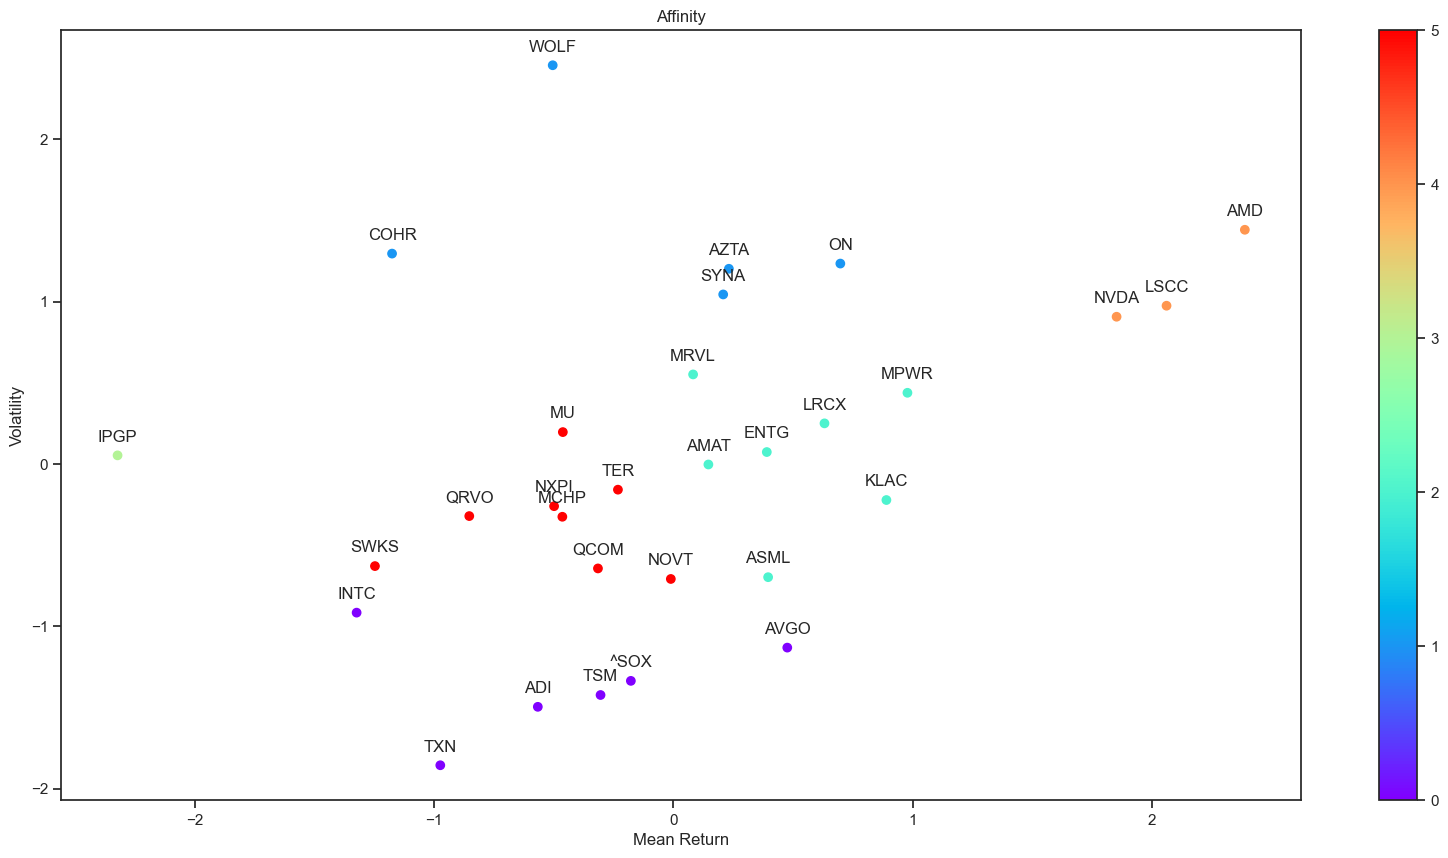

In [43]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [44]:
cluster_label.sort_values(by=['Cluster']).head()

,Company,Cluster
29,^SOX,0
1,ADI,0
25,TSM,0
27,TXN,0
5,AVGO,0


['ADI', 'AVGO', 'INTC', 'TSM', 'TXN', '^SOX']


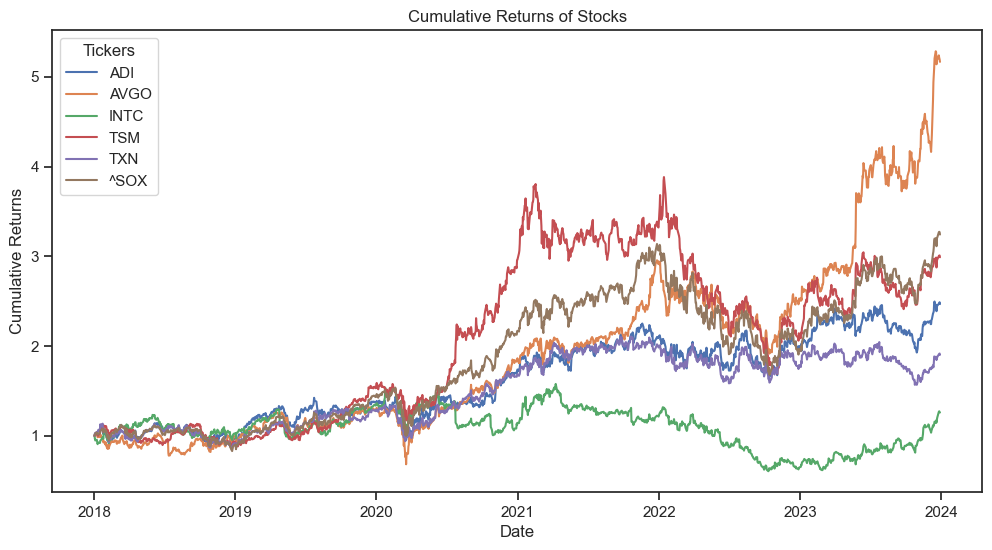

['AZTA', 'COHR', 'ON', 'SYNA', 'WOLF']


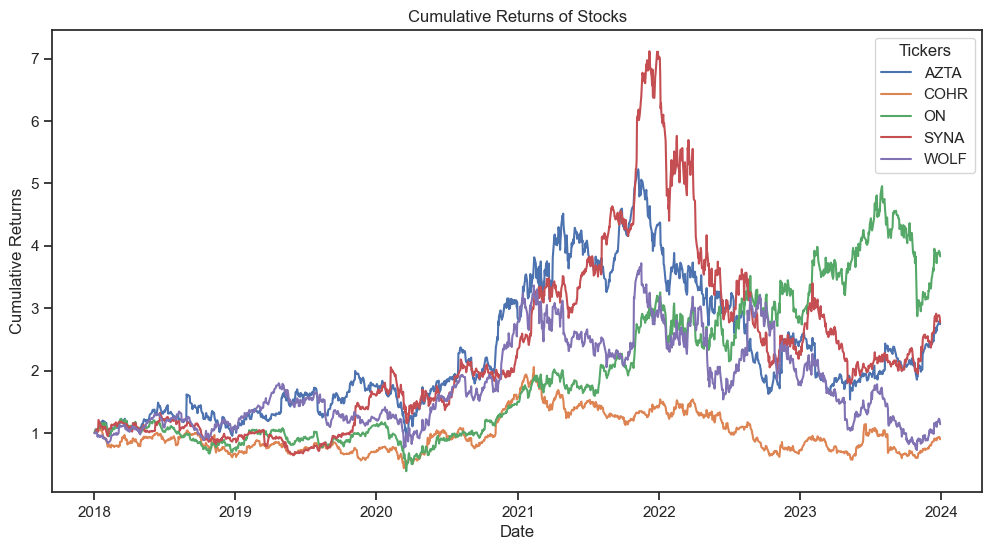

['AMAT', 'ASML', 'ENTG', 'KLAC', 'LRCX', 'MRVL', 'MPWR']


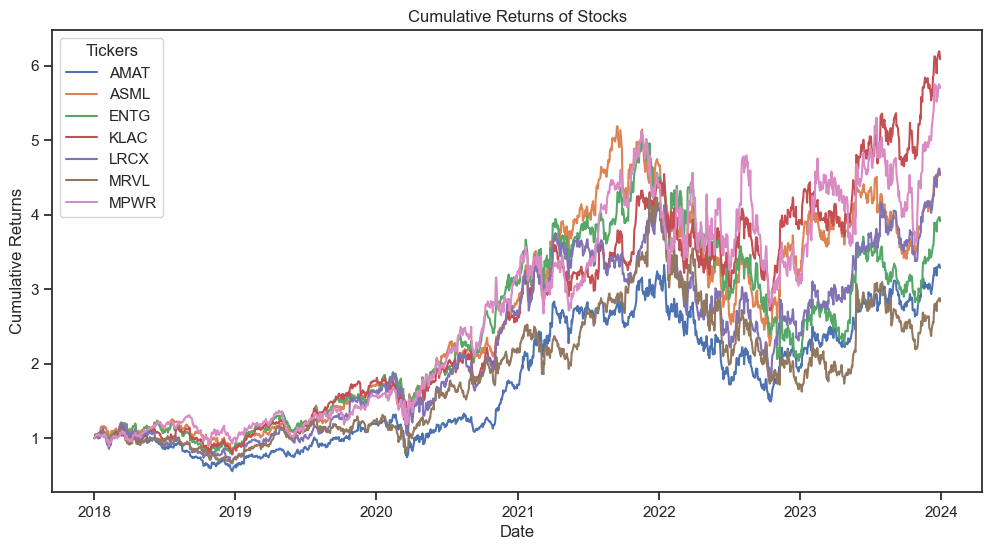

['IPGP']


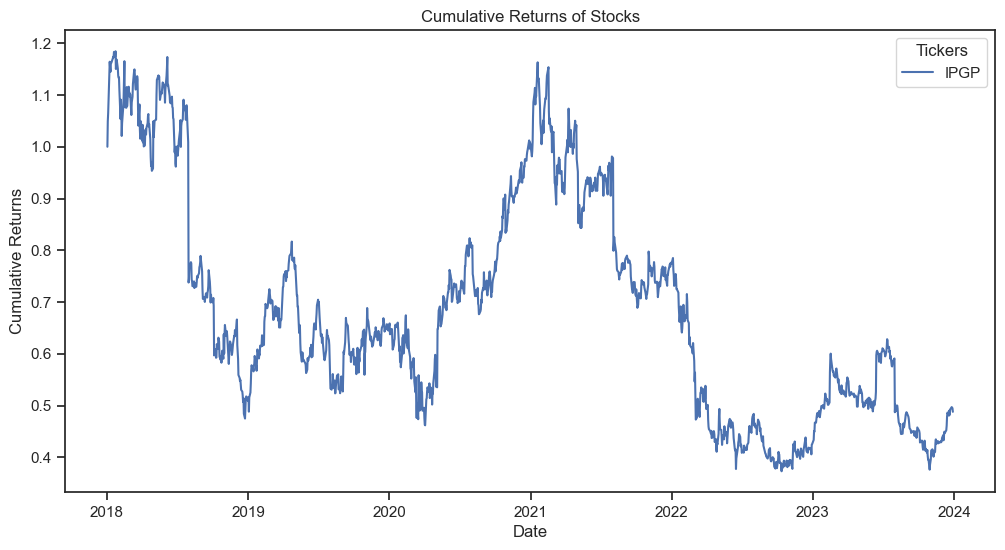

['AMD', 'LSCC', 'NVDA']


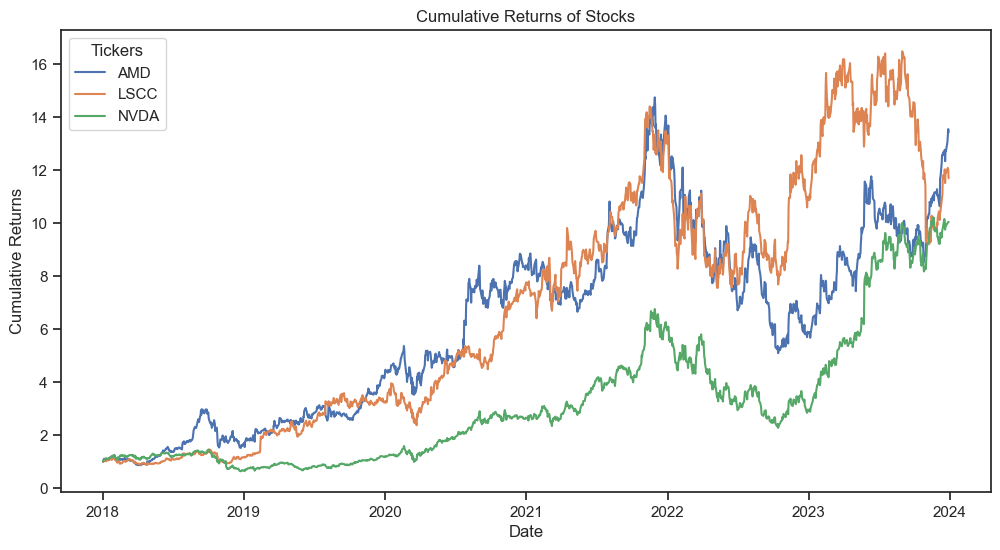

['MCHP', 'MU', 'NOVT', 'NXPI', 'QRVO', 'QCOM', 'SWKS', 'TER']


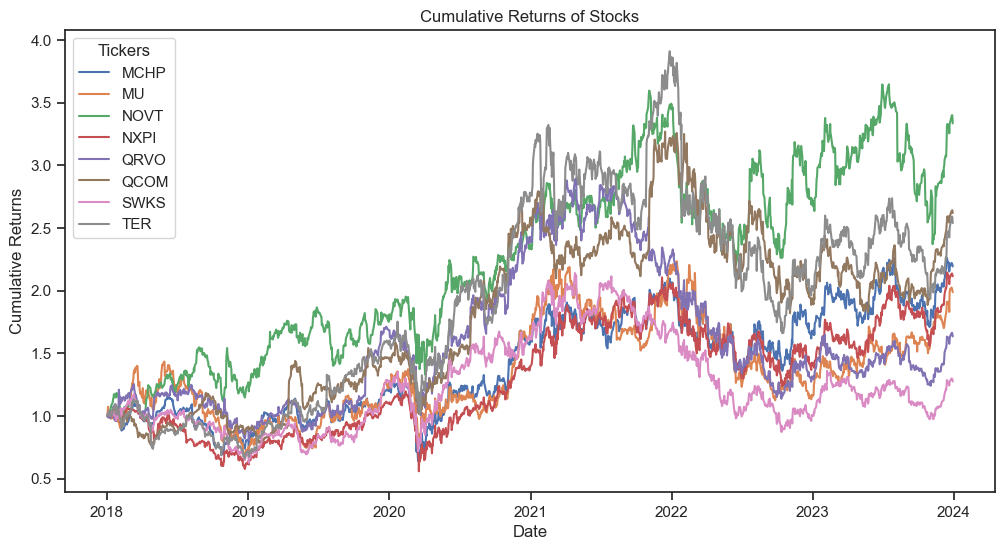

In [39]:
for i in range(0,6):    
    # Retrieve the first row (the starting point)
    print(list(cluster_label[cluster_label['Cluster']==i].Company))
    first_row = prices[list(cluster_label[cluster_label['Cluster']==i].Company)].iloc[0]
    
    # Calculate the cumulative returns
    # We divide each day's prices by the first day's prices
    cumulative_returns = prices[list(cluster_label[cluster_label['Cluster']==i].Company)] / first_row

    # Plotting the evolution
    # Setting the seaborn style
    sns.set(style="ticks")
    # Plotting the evolution using seaborn's lineplot
    plt.figure(figsize=(12, 6))
    for column in cumulative_returns.columns:
        sns.lineplot(data=cumulative_returns[column], label=column)

    plt.title("Cumulative Returns of Stocks")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend(title="Tickers")
    plt.show()


# AutoEncoder

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers, optimizers
from sklearn.preprocessing import MinMaxScaler

np.random.seed(101)

In [48]:
df_pct_change = prices.pct_change(1).astype(float)
df_pct_change = df_pct_change.replace([np.inf, -np.inf], np.nan)
df_pct_change = df_pct_change.fillna(method='ffill')

# the percentage change function will make the first two rows equal to nan
df_pct_change = df_pct_change.tail(len(df_pct_change) - 2)

In [88]:
df_pct_change=df_pct_change.iloc[:, :29]

In [89]:
# Normalize the data
df_scaler = MinMaxScaler()
df_pct_change_normalised = df_scaler.fit_transform(df_pct_change)

In [90]:
def create_autoencoder(learning_rate, lambda_reg, dropout_rate, num_stock, encoding_dim):
    """
    Creates, compiles, and returns an autoencoder based on specified parameters.
    :param learning_rate: Learning rate for the Adam optimizer.
    :param lambda_reg: Coefficient for L2 regularization applied to each Dense layer.
    :param dropout_rate: Dropout rate to reduce overfitting, applied after certain Dense layers.
    :param num_stock: Number of neurons in the input layer, corresponding to the dimension of the input data.
    :param encoding_dim: Size of the encoded representation, i.e., the number of neurons in the encoding layer.
    :return: A compiled Sequential autoencoder model.
    """
    # Initialize the Sequential model
    autoencoder = Sequential()
    # Add the input layer with the specified dimension
    autoencoder.add(Input(shape=(num_stock,)))
    # Add encoder hidden layers with L2 regularization and dropout
    # first hidden layers
    autoencoder.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(lambda_reg)))
    autoencoder.add(Dropout(dropout_rate))
    # second hidden Layers
    autoencoder.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(lambda_reg)))
    # Add the encoding layer, representing the compressed representation
    autoencoder.add(Dense(encoding_dim, kernel_regularizer=regularizers.l2(lambda_reg), name='Encoder_Input'))
    # Add decoder hidden layers, similar to encoder but in reverse
    # first hidden layers
    autoencoder.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(lambda_reg)))
    autoencoder.add(Dropout(dropout_rate))
    # second hidden Layers
    autoencoder.add(Dense(15, activation='relu', kernel_regularizer=regularizers.l2(lambda_reg)))
    # Add the decoder output layer to reconstruct the input
    autoencoder.add(Dense(num_stock, activation='linear', kernel_regularizer=regularizers.l2(lambda_reg), name='Decoder_Input'))
    # Configure the optimizer with the specified learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    # Compile the model with the optimizer and loss function
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return autoencoder

In [97]:
def getReconstructionErrorsDF(df_pct_change, reconstructed_data):
    
    """
    Function for calculating the reconstruction Errors
    """
    array = []
    stocks_ranked = []
    num_columns = reconstructed_data.shape[1]
    for i in range(0, num_columns):
        diff = np.linalg.norm((df_pct_change.iloc[:, i] - reconstructed_data[:, i]))  # 2 norm difference
        array.append(float(diff))

    ranking = np.array(array).argsort()
    r = 1
    for stock_index in ranking:
        stocks_ranked.append([ r
                              ,stock_index
                              ,df_pct_change.iloc[:, stock_index].name
                              ,array[stock_index]
                              ])
        r = r + 1

    columns = ['ranking','stock_index', 'stock_name' ,'recreation_error']
    df = pd.DataFrame(stocks_ranked, columns=columns)
    df = df.set_index('stock_name')
    return df

In [107]:
# define the input parameters
hidden_layers = 5
batch_size = 500
epochs = 500
stock_selection_number = 10
num_stock = df_pct_change.shape[1]
verbose = 1
learning_rate=0.0004
lambda_reg=0.12
dropout_rate=0.80
num_stock=29
encoding_dim=5

In [108]:
# Exemple d'utilisation de la fonction
autoencoder_model = create_autoencoder(learning_rate, lambda_reg, dropout_rate, num_stock, encoding_dim)
autoencoder_model.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 15)                450       
                                                                 
 dropout_14 (Dropout)        (None, 15)                0         
                                                                 
 dense_29 (Dense)            (None, 10)                160       
                                                                 
 Encoder_Input (Dense)       (None, 5)                 55        
                                                                 
 dense_30 (Dense)            (None, 10)                60        
                                                                 
 dropout_15 (Dropout)        (None, 10)                0         
                                                                 
 dense_31 (Dense)            (None, 15)               

In [109]:
# Fitting
autoencoder_model.fit(df_pct_change_normalised, 
                      df_pct_change_normalised, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_split=0.2)

Epoch 1/500
3/3 [==============================] - 1s 25ms/step - loss: 9.7352 - val_loss: 9.3035
Epoch 2/500
3/3 [==============================] - 0s 5ms/step - loss: 9.6191 - val_loss: 9.2350
Epoch 3/500
3/3 [==============================] - 0s 5ms/step - loss: 9.4678 - val_loss: 9.1666
Epoch 4/500
3/3 [==============================] - 0s 5ms/step - loss: 9.4227 - val_loss: 9.0985
Epoch 5/500
3/3 [==============================] - 0s 6ms/step - loss: 9.2708 - val_loss: 9.0304
Epoch 6/500
3/3 [==============================] - 0s 5ms/step - loss: 9.2486 - val_loss: 8.9623
Epoch 7/500
3/3 [==============================] - 0s 5ms/step - loss: 9.1423 - val_loss: 8.8944
Epoch 8/500
3/3 [==============================] - 0s 5ms/step - loss: 9.0451 - val_loss: 8.8266
Epoch 9/500
3/3 [==============================] - 0s 5ms/step - loss: 8.9630 - val_loss: 8.7591
Epoch 10/500
3/3 [==============================] - 0s 5ms/step - loss: 8.8738 - val_loss: 8.6918
Epoch 11/500
3/3 [==========

3/3 [==============================] - 0s 4ms/step - loss: 4.8401 - val_loss: 4.8097
Epoch 85/500
3/3 [==============================] - 0s 4ms/step - loss: 4.8022 - val_loss: 4.7709
Epoch 86/500
3/3 [==============================] - 0s 4ms/step - loss: 4.7624 - val_loss: 4.7323
Epoch 87/500
3/3 [==============================] - 0s 4ms/step - loss: 4.7255 - val_loss: 4.6941
Epoch 88/500
3/3 [==============================] - 0s 4ms/step - loss: 4.6855 - val_loss: 4.6561
Epoch 89/500
3/3 [==============================] - 0s 4ms/step - loss: 4.6489 - val_loss: 4.6185
Epoch 90/500
3/3 [==============================] - 0s 4ms/step - loss: 4.6090 - val_loss: 4.5811
Epoch 91/500
3/3 [==============================] - 0s 4ms/step - loss: 4.5728 - val_loss: 4.5440
Epoch 92/500
3/3 [==============================] - 0s 4ms/step - loss: 4.5351 - val_loss: 4.5072
Epoch 93/500
3/3 [==============================] - 0s 4ms/step - loss: 4.4992 - val_loss: 4.4707
Epoch 94/500
3/3 [===============

3/3 [==============================] - 0s 4ms/step - loss: 2.4446 - val_loss: 2.4303
Epoch 168/500
3/3 [==============================] - 0s 4ms/step - loss: 2.4245 - val_loss: 2.4101
Epoch 169/500
3/3 [==============================] - 0s 4ms/step - loss: 2.4041 - val_loss: 2.3901
Epoch 170/500
3/3 [==============================] - 0s 4ms/step - loss: 2.3842 - val_loss: 2.3702
Epoch 171/500
3/3 [==============================] - 0s 4ms/step - loss: 2.3643 - val_loss: 2.3505
Epoch 172/500
3/3 [==============================] - 0s 4ms/step - loss: 2.3445 - val_loss: 2.3309
Epoch 173/500
3/3 [==============================] - 0s 5ms/step - loss: 2.3252 - val_loss: 2.3115
Epoch 174/500
3/3 [==============================] - 0s 4ms/step - loss: 2.3058 - val_loss: 2.2922
Epoch 175/500
3/3 [==============================] - 0s 4ms/step - loss: 2.2866 - val_loss: 2.2731
Epoch 176/500
3/3 [==============================] - 0s 4ms/step - loss: 2.2675 - val_loss: 2.2542
Epoch 177/500
3/3 [=====

Epoch 250/500
3/3 [==============================] - 0s 4ms/step - loss: 1.2104 - val_loss: 1.2030
Epoch 251/500
3/3 [==============================] - 0s 4ms/step - loss: 1.2000 - val_loss: 1.1927
Epoch 252/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1898 - val_loss: 1.1825
Epoch 253/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1796 - val_loss: 1.1724
Epoch 254/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1695 - val_loss: 1.1623
Epoch 255/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1594 - val_loss: 1.1524
Epoch 256/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1495 - val_loss: 1.1425
Epoch 257/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1396 - val_loss: 1.1327
Epoch 258/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1299 - val_loss: 1.1230
Epoch 259/500
3/3 [==============================] - 0s 4ms/step - loss: 1.1202 - val_loss: 1.1133
Epoch 260/

3/3 [==============================] - 0s 4ms/step - loss: 0.5926 - val_loss: 0.5888
Epoch 333/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5874 - val_loss: 0.5836
Epoch 334/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5822 - val_loss: 0.5785
Epoch 335/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5771 - val_loss: 0.5734
Epoch 336/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5721 - val_loss: 0.5683
Epoch 337/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5670 - val_loss: 0.5633
Epoch 338/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5620 - val_loss: 0.5584
Epoch 339/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5571 - val_loss: 0.5535
Epoch 340/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5522 - val_loss: 0.5486
Epoch 341/500
3/3 [==============================] - 0s 4ms/step - loss: 0.5473 - val_loss: 0.5437
Epoch 342/500
3/3 [=====

Epoch 415/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2826 - val_loss: 0.2805
Epoch 416/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2801 - val_loss: 0.2780
Epoch 417/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2776 - val_loss: 0.2755
Epoch 418/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2751 - val_loss: 0.2730
Epoch 419/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2726 - val_loss: 0.2706
Epoch 420/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2702 - val_loss: 0.2681
Epoch 421/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2677 - val_loss: 0.2657
Epoch 422/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2653 - val_loss: 0.2633
Epoch 423/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2630 - val_loss: 0.2610
Epoch 424/500
3/3 [==============================] - 0s 4ms/step - loss: 0.2606 - val_loss: 0.2586
Epoch 425/

3/3 [==============================] - 0s 4ms/step - loss: 0.1342 - val_loss: 0.1329
Epoch 498/500
3/3 [==============================] - 0s 4ms/step - loss: 0.1330 - val_loss: 0.1317
Epoch 499/500
3/3 [==============================] - 0s 4ms/step - loss: 0.1318 - val_loss: 0.1305
Epoch 500/500
3/3 [==============================] - 0s 4ms/step - loss: 0.1306 - val_loss: 0.1293


In [110]:
# predict autoencoder
print('-' * 25 + 'Predict autoencoder model')
reconstruct = autoencoder_model.predict(df_pct_change_normalised)

-------------------------Predict autoencoder model
48/48 [==============================] - 0s 297us/step


In [111]:
# Inverse transform dataset with MinMax Scaler
print('-' * 25 + 'Inverse transform dataset with MinMax Scaler')
reconstruct_real = df_scaler.inverse_transform(reconstruct)
df_reconstruct_real = pd.DataFrame(data=reconstruct_real, columns=df_pct_change.columns)

-------------------------Inverse transform dataset with MinMax Scaler


In [112]:
print('-' * 25 + 'Calculate L2 norm as reconstruction loss metric')
df_recreation_error = getReconstructionErrorsDF(df_pct_change=df_pct_change,
                                                reconstructed_data=reconstruct_real)

-------------------------Calculate L2 norm as reconstruction loss metric


In [114]:
df_recreation_error

,ranking,stock_index,recreation_error
stock_name,,,
TXN,1,27,0.921905
NOVT,2,17,1.026651
QCOM,3,22,1.084832
QRVO,4,21,1.151377
MRVL,5,13,1.196001
SWKS,6,23,1.262401
TSM,7,25,1.272336
AZTA,8,4,1.325241
LSCC,9,12,1.331084


In [250]:
Autoencoder_stocks = list(df_recreation_error.head(10).index)
Autoencoder_stocks.append('^SOX')



# Gradient Descent Optimization

#### Objective function

The objective function is defined by :
\begin{equation}
f(W) = (R_i - R_xW)^T(R_i - R_xW) - k(W^TW)
\end{equation}
where $R_i$ and $R_x$ are known matrices, $W$ is the variable matrix, and $k$ is a scalar and $k(W^TW)$ is the regularized term

#### Gradient of the function

The gradient of $f(W)$ with respect to $W$ is calculated as follows:

\begin{align}
\nabla f(W) &= -2R_x^T(R_i - R_xW) - 2kW
\end{align}

#### Gradient descent algorithm

The algorithm for minimizing $f(W)$ is shown below:

**Algorithm: Gradient descent to minimize $f(W)$**

1. **Set** $W$ to an arbitrary value.
2. Choose a learning rate $\alpha$ and a convergence threshold $\epsilon$.
3. **Repeat** :
   - Calculate the gradient $\nabla f(W)$.
   - Update $W \leftarrow W - \alpha \nabla f(W)$.
4. **Until** the norm of $\nabla f(W)$ is less than $\epsilon$.


In [196]:
np.random.seed(101) 
class GradientDescentOptimizer:
    def __init__(self, R_i, R_x, alpha=0.01, epsilon=1e-6, max_iter=10000):
        self.R_i = R_i  # Return vector for asset/portfolio i (n, 1)
        self.R_x = R_x  # Matrix of explanatory variables/factors (n, k)
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Convergence threshold
        self.max_iter = max_iter  # Maximum number of iterations

    def calculate_gradient(self, W, k):
        # Calculate the gradient of the cost function
        predictions = np.dot(self.R_x, W)
        error = self.R_i - predictions
        gradient = -2 * np.dot(self.R_x.T, error) + 2 * k * W
        return gradient

    def cost_function(self, W, k):
        # Calculate the cost function including the regularization term
        predictions = np.dot(self.R_x, W)
        error = self.R_i - predictions
        cost = np.dot(error.T, error) + k * np.dot(W.T, W)
        return cost.item()

    def optimize_W_for_k(self, k):
        W = np.random.randn(self.R_x.shape[1], 1)  # Initialize W as a vector (k, 1)
        for _ in range(self.max_iter):
            gradient = self.calculate_gradient(W, k)
            W -= self.alpha * gradient
            if np.linalg.norm(gradient) < self.epsilon:
                break
        return W, self.cost_function(W, k)

    def find_best_k(self, k_values):
        min_cost = np.inf
        best_k = None
        best_W = None
        for k in k_values:
            W, cost = self.optimize_W_for_k(k)
            if cost < min_cost:
                min_cost = cost
                best_k = k
                best_W = W
        return best_k, best_W, min_cost

## Tracking Problem resolution 

#### Tracking Using all stocks

In [326]:
#df of return
df=prices.pct_change().iloc[1:]

#Split data into train and test
split_point = int(len(df) * 0.7)
train_data = df[:split_point]
test_data = df[split_point:]

#Optimization 
R_i = np.array(train_data[['^SOX']])  # Returns for asset/portfolio i (n, 1)
R_x = np.array(train_data.iloc[:,:29])  # Explanatory variables/factors (n, k)
optimizer = GradientDescentOptimizer(R_i, R_x)
k_values = np.linspace(0.01, 1, 100)  # k values to test
best_k, best_W_full, min_cost = optimizer.find_best_k(k_values)

#Best Parameters
print("Best k:", best_k)
print("Optimized W:")
print(best_W_full*100)
print("Minimum cost:", min_cost)

Best k: 0.01
Optimized W:
[[ 4.51893286e+00]
 [ 4.09294633e+00]
 [ 4.40521839e+00]
 [ 3.06520324e+00]
 [ 4.12501035e-01]
 [ 6.99759178e+00]
 [-4.99859741e-03]
 [ 2.00937088e+00]
 [ 7.99908200e+00]
 [ 5.18390672e-01]
 [ 4.05188741e+00]
 [ 4.07079968e+00]
 [ 2.57237494e-01]
 [ 3.47672810e+00]
 [ 4.53586506e+00]
 [ 3.68110118e+00]
 [ 2.74309341e+00]
 [ 2.69174699e-01]
 [ 7.91918727e+00]
 [ 2.24840485e+00]
 [ 1.56887407e+00]
 [ 2.15162201e+00]
 [ 8.48718941e+00]
 [ 2.77045666e+00]
 [ 1.77905579e-01]
 [ 4.97515158e+00]
 [ 2.37074207e+00]
 [ 8.80360028e+00]
 [ 1.01295409e+00]]
Minimum cost: 0.001620327401858098


In [216]:
best_W_full.sum()

0.9958622118704334

#### Tracking with AutoEncoder Selection 

In [252]:
#df of return
df=prices[Autoencoder_stocks].pct_change().iloc[1:]

#Split data into train and test
split_point = int(len(df) * 0.7)
train_data = df[:split_point]
test_data = df[split_point:]

#Optimization 
R_i = np.array(train_data[['^SOX']])  # Returns for asset/portfolio i (n, 1)
R_x = np.array(train_data.iloc[:,:10])  # Explanatory variables/factors (n, k)
optimizer = GradientDescentOptimizer(R_i, R_x)
k_values = np.linspace(0.01, 1, 100)  # k values to test
best_k, best_W_AE, min_cost = optimizer.find_best_k(k_values)

#Best Parameters
print("Best k:", best_k)
print("Optimized W:")
print(best_W_AE*100)
print("Minimum cost:", min_cost)

In [ ]:
best_W_AE.sum()

#### Tracking with Affinity Propagation Selection 

In [314]:
# Initialize an empty list to hold all affinity selections
affinity_selections = []

# Iterate through the cluster numbers you're interested in combining with cluster 0
for cluster_num in range(1, 6): 
    # Create a selection list by starting with companies from cluster 0
    selection = list(cluster_label[cluster_label['Cluster'] == 0].Company)
    
    # Extend the selection by adding companies from the current cluster
    selection.extend(list(cluster_label[cluster_label['Cluster'] == cluster_num].Company))
    
    # Remove the specific company '^SOX' from the selection
    if '^SOX' in selection:
        selection.remove('^SOX')
    
    # Add the final selection to the list of all selections
    affinity_selections.append(selection)

In [338]:
#df of return
df=prices[affinity_selections[0]].pct_change().iloc[1:]

#Split data into train and test
split_point = int(len(df) * 0.7)
train_data = df[:split_point]
test_data = df[split_point:]

#Optimization 
R_i = np.array(prices[['^SOX']].pct_change().iloc[1:][:split_point])  # Returns for asset/portfolio i (n, 1)
R_x = np.array(train_data.iloc[:,:len(df.columns)])  # Explanatory variables/factors (n, k)
optimizer = GradientDescentOptimizer(R_i, R_x)
k_values = np.linspace(0.01, 1, 100)  # k values to test
best_k, best_W_AF1, min_cost = optimizer.find_best_k(k_values)

In [339]:
#df of return
df=prices[affinity_selections[1]].pct_change().iloc[1:]

#Split data into train and test
split_point = int(len(df) * 0.7)
train_data = df[:split_point]
test_data = df[split_point:]

#Optimization 
R_i = np.array(prices[['^SOX']].pct_change().iloc[1:][:split_point])  # Returns for asset/portfolio i (n, 1)
R_x = np.array(train_data.iloc[:,:len(df.columns)])  # Explanatory variables/factors (n, k)
optimizer = GradientDescentOptimizer(R_i, R_x)
k_values = np.linspace(0.01, 1, 100)  # k values to test
best_k, best_W_AF2, min_cost = optimizer.find_best_k(k_values)

In [340]:
#df of return
df=prices[affinity_selections[2]].pct_change().iloc[1:]

#Split data into train and test
split_point = int(len(df) * 0.7)
train_data = df[:split_point]
test_data = df[split_point:]

#Optimization 
R_i = np.array(prices[['^SOX']].pct_change().iloc[1:][:split_point])  # Returns for asset/portfolio i (n, 1)
R_x = np.array(train_data.iloc[:,:len(df.columns)])  # Explanatory variables/factors (n, k)
optimizer = GradientDescentOptimizer(R_i, R_x)
k_values = np.linspace(0.01, 1, 100)  # k values to test
best_k, best_W_AF3, min_cost = optimizer.find_best_k(k_values)

In [341]:
#df of return
df=prices[affinity_selections[3]].pct_change().iloc[1:]

#Split data into train and test
split_point = int(len(df) * 0.7)
train_data = df[:split_point]
test_data = df[split_point:]

#Optimization 
R_i = np.array(prices[['^SOX']].pct_change().iloc[1:][:split_point])  # Returns for asset/portfolio i (n, 1)
R_x = np.array(train_data.iloc[:,:len(df.columns)])  # Explanatory variables/factors (n, k)
optimizer = GradientDescentOptimizer(R_i, R_x)
k_values = np.linspace(0.01, 1, 100)  # k values to test
best_k, best_W_AF4, min_cost = optimizer.find_best_k(k_values)

In [342]:
#df of return
df=prices[affinity_selections[4]].pct_change().iloc[1:]

#Split data into train and test
split_point = int(len(df) * 0.7)
train_data = df[:split_point]
test_data = df[split_point:]

#Optimization 
R_i = np.array(prices[['^SOX']].pct_change().iloc[1:][:split_point])  # Returns for asset/portfolio i (n, 1)
R_x = np.array(train_data.iloc[:,:len(df.columns)])  # Explanatory variables/factors (n, k)
optimizer = GradientDescentOptimizer(R_i, R_x)
k_values = np.linspace(0.01, 1, 100)  # k values to test
best_k, best_W_AF5, min_cost = optimizer.find_best_k(k_values)

#### Evolution of returns 

#### Evolution of cumulative return Train Period 

In [346]:
# Calcul du Benchmark
Index = prices[:split_point]['^SOX'] / prices[:split_point]['^SOX'].iloc[0]

# Calcul des rendements quotidiens des actifs dans le portefeuille
daily_returns_full = prices.pct_change().iloc[1:][:split_point].drop(columns=['^SOX'])
daily_returns_AE = prices[Autoencoder_stocks].pct_change().iloc[1:][:split_point].drop(columns=['^SOX'])
daily_returns_AF1 = prices[affinity_selections[0]].pct_change().iloc[1:][:split_point]
daily_returns_AF2 = prices[affinity_selections[1]].pct_change().iloc[1:][:split_point]
daily_returns_AF3 = prices[affinity_selections[2]].pct_change().iloc[1:][:split_point]
daily_returns_AF4 = prices[affinity_selections[3]].pct_change().iloc[1:][:split_point]
daily_returns_AF5 = prices[affinity_selections[4]].pct_change().iloc[1:][:split_point]

# Poids des actifs dans le portefeuille
weights_full = [item[0] for item in best_W_full.tolist()]
weights_AE = [item[0] for item in best_W_AE.tolist()]
weights_AF1 = [item[0] for item in best_W_AF1.tolist()]
weights_AF2 = [item[0] for item in best_W_AF2.tolist()]
weights_AF3 = [item[0] for item in best_W_AF3.tolist()]
weights_AF4 = [item[0] for item in best_W_AF4.tolist()]
weights_AF5 = [item[0] for item in best_W_AF5.tolist()]

# Calcul des rendements pondérés du portefeuille
Tracking_portfolio_full = (daily_returns_full * weights_full).sum(axis=1)
Tracking_portfolio_AE = (daily_returns_AE * weights_AE).sum(axis=1)
Tracking_portfolio_AF1 = (daily_returns_AF1 * weights_AF1).sum(axis=1)
Tracking_portfolio_AF2 = (daily_returns_AF2 * weights_AF2).sum(axis=1)
Tracking_portfolio_AF3 = (daily_returns_AF3 * weights_AF3).sum(axis=1)
Tracking_portfolio_AF4 = (daily_returns_AF4 * weights_AF4).sum(axis=1)
Tracking_portfolio_AF5 = (daily_returns_AF5 * weights_AF5).sum(axis=1)


# Calcul des rendements cumulés du portefeuille
cumulative_return_full = (1 + Tracking_portfolio_full).cumprod()
cumulative_return_AE = (1 + Tracking_portfolio_AE).cumprod()
cumulative_return_AF1 = (1 + Tracking_portfolio_AF1).cumprod()
cumulative_return_AF2 = (1 + Tracking_portfolio_AF2).cumprod()
cumulative_return_AF3 = (1 + Tracking_portfolio_AF3).cumprod()
cumulative_return_AF4 = (1 + Tracking_portfolio_AF4).cumprod()
cumulative_return_AF5 = (1 + Tracking_portfolio_AF5).cumprod()


# Création du DataFrame
results_df = pd.DataFrame({
    'SOX': Index,
    'Tracking Portfolio Full': cumulative_return_full,
    'Tracking Portfolio AE': cumulative_return_AE,
    'Tracking Portfolio AF1': cumulative_return_AF1,
    'Tracking Portfolio AF2': cumulative_return_AF2,
    'Tracking Portfolio AF3': cumulative_return_AF3,
    'Tracking Portfolio AF4': cumulative_return_AF4,
    'Tracking Portfolio AF5': cumulative_return_AF5
})

results_df=results_df.dropna()

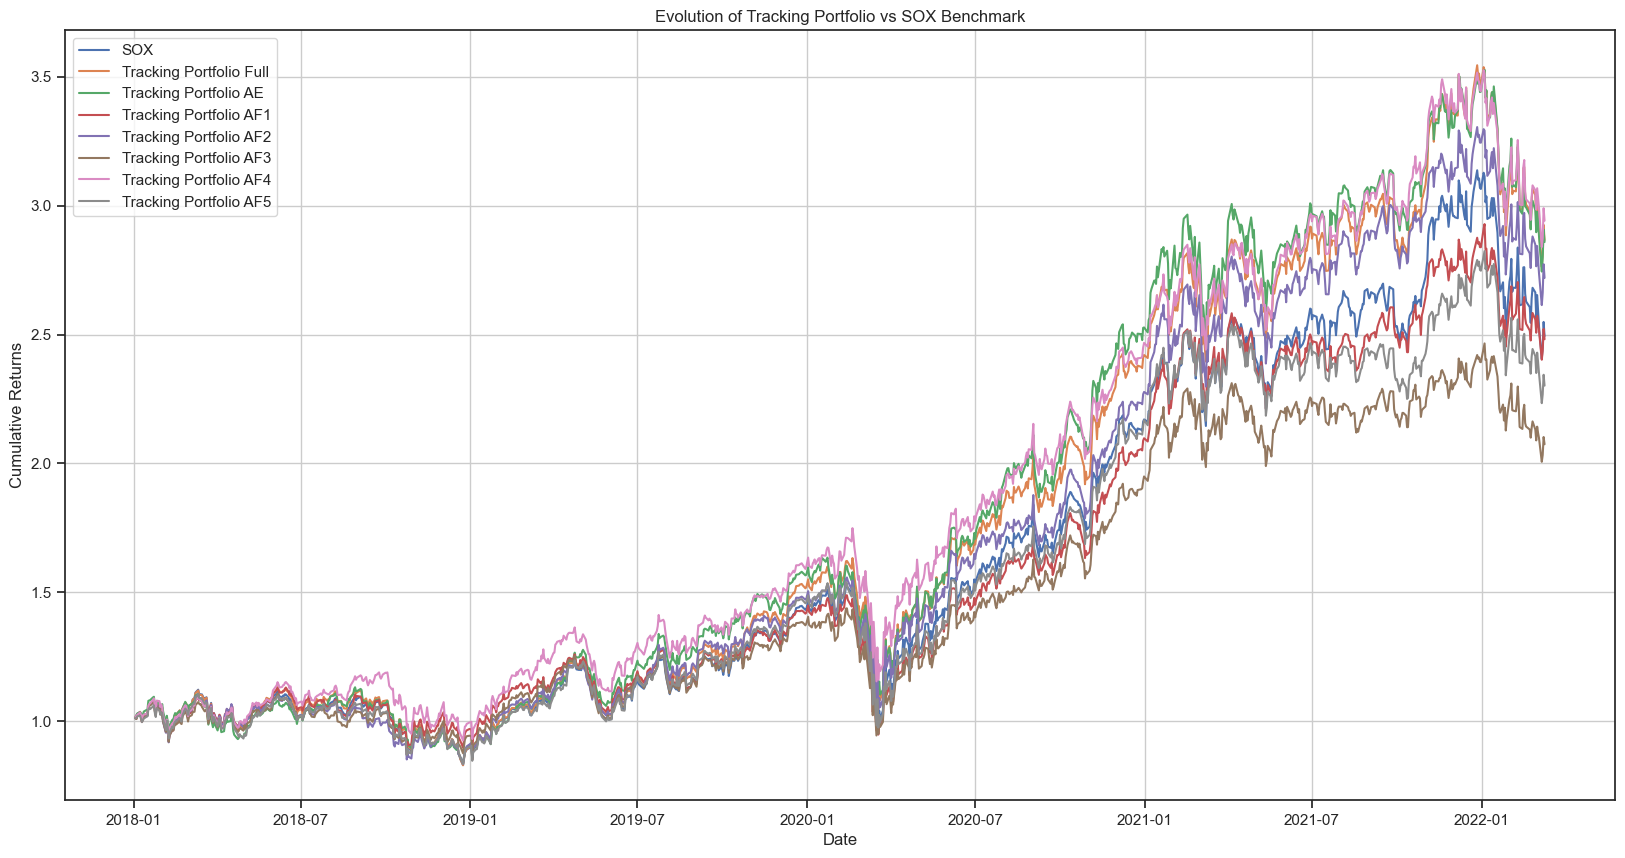

In [348]:
plt.figure(figsize=(20, 10))
plt.plot(results_df['SOX'], label='SOX')
plt.plot(results_df['Tracking Portfolio Full'], label='Tracking Portfolio Full')
plt.plot(results_df['Tracking Portfolio AE'], label='Tracking Portfolio AE')
plt.plot(results_df['Tracking Portfolio AF1'], label='Tracking Portfolio AF1')
plt.plot(results_df['Tracking Portfolio AF2'], label='Tracking Portfolio AF2')
plt.plot(results_df['Tracking Portfolio AF3'], label='Tracking Portfolio AF3')
plt.plot(results_df['Tracking Portfolio AF4'], label='Tracking Portfolio AF4')
plt.plot(results_df['Tracking Portfolio AF5'], label='Tracking Portfolio AF5')


plt.title('Evolution of Tracking Portfolio vs SOX Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

#### Evolution of cumulative return Test Period 

In [354]:
# Calcul du Benchmark
Index = prices[split_point:]['^SOX'] / prices[split_point:]['^SOX'].iloc[0]

# Calcul des rendements quotidiens des actifs dans le portefeuille
daily_returns_full = prices.pct_change().iloc[1:][split_point:].drop(columns=['^SOX'])
daily_returns_AE = prices[Autoencoder_stocks].pct_change().iloc[1:][split_point:].drop(columns=['^SOX'])
daily_returns_AF1 = prices[affinity_selections[0]].pct_change().iloc[1:][split_point:]
daily_returns_AF2 = prices[affinity_selections[1]].pct_change().iloc[1:][split_point:]
daily_returns_AF3 = prices[affinity_selections[2]].pct_change().iloc[1:][split_point:]
daily_returns_AF4 = prices[affinity_selections[3]].pct_change().iloc[1:][split_point:]
daily_returns_AF5 = prices[affinity_selections[4]].pct_change().iloc[1:][split_point:]

# Poids des actifs dans le portefeuille
weights_full =[item[0] for item in best_W_full.tolist()]
weights_AE  = [item[0] for item in best_W_AE.tolist()]
weights_AF1 = [item[0] for item in best_W_AF1.tolist()]
weights_AF2 = [item[0] for item in best_W_AF2.tolist()]
weights_AF3 = [item[0] for item in best_W_AF3.tolist()]
weights_AF4 = [item[0] for item in best_W_AF4.tolist()]
weights_AF5 = [item[0] for item in best_W_AF5.tolist()]

# Calcul des rendements pondérés du portefeuille
Tracking_portfolio_full = (daily_returns_full * weights_full).sum(axis=1)
Tracking_portfolio_AE = (daily_returns_AE * weights_AE).sum(axis=1)
Tracking_portfolio_AF1 = (daily_returns_AF1 * weights_AF1).sum(axis=1)
Tracking_portfolio_AF2 = (daily_returns_AF2 * weights_AF2).sum(axis=1)
Tracking_portfolio_AF3 = (daily_returns_AF3 * weights_AF3).sum(axis=1)
Tracking_portfolio_AF4 = (daily_returns_AF4 * weights_AF4).sum(axis=1)
Tracking_portfolio_AF5 = (daily_returns_AF5 * weights_AF5).sum(axis=1)


# Calcul des rendements cumulés du portefeuille
cumulative_return_full = (1 + Tracking_portfolio_full).cumprod()
cumulative_return_AE = (1 + Tracking_portfolio_AE).cumprod()
cumulative_return_AF1 = (1 + Tracking_portfolio_AF1).cumprod()
cumulative_return_AF2 = (1 + Tracking_portfolio_AF2).cumprod()
cumulative_return_AF3 = (1 + Tracking_portfolio_AF3).cumprod()
cumulative_return_AF4 = (1 + Tracking_portfolio_AF4).cumprod()
cumulative_return_AF5 = (1 + Tracking_portfolio_AF5).cumprod()


# Création du DataFrame
results_df = pd.DataFrame({
    'SOX': Index,
    'Tracking Portfolio Full': cumulative_return_full,
    'Tracking Portfolio AE': cumulative_return_AE,
    'Tracking Portfolio AF1': cumulative_return_AF1,
    'Tracking Portfolio AF2': cumulative_return_AF2,
    'Tracking Portfolio AF3': cumulative_return_AF3,
    'Tracking Portfolio AF4': cumulative_return_AF4,
    'Tracking Portfolio AF5': cumulative_return_AF5
})

results_df=results_df.dropna()

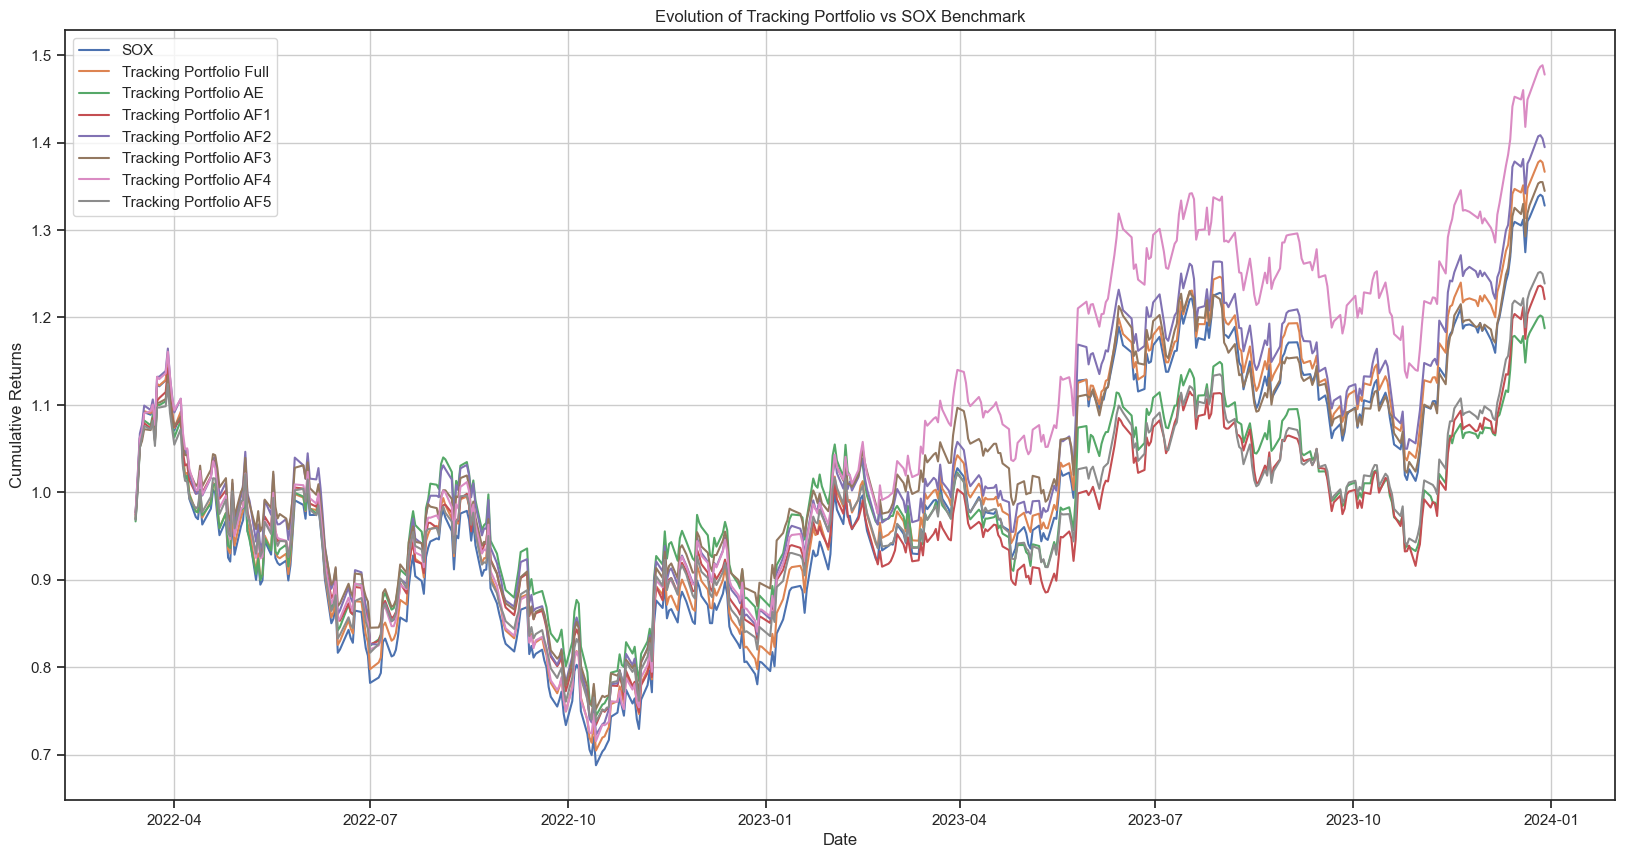

In [356]:
plt.figure(figsize=(20, 10))
plt.plot(results_df['SOX'], label='SOX')
plt.plot(results_df['Tracking Portfolio Full'], label='Tracking Portfolio Full')
plt.plot(results_df['Tracking Portfolio AE'], label='Tracking Portfolio AE')
plt.plot(results_df['Tracking Portfolio AF1'], label='Tracking Portfolio AF1')
plt.plot(results_df['Tracking Portfolio AF2'], label='Tracking Portfolio AF2')
plt.plot(results_df['Tracking Portfolio AF3'], label='Tracking Portfolio AF3')
plt.plot(results_df['Tracking Portfolio AF4'], label='Tracking Portfolio AF4')
plt.plot(results_df['Tracking Portfolio AF5'], label='Tracking Portfolio AF5')


plt.title('Evolution of Tracking Portfolio vs SOX Benchmark')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()